In [ ]:
!pip install -q transformers datasets

In [ ]:
from datasets import load_dataset

# we can load a custom dataset using the "imagefolder" feature
# details: http://huggingface.co/docs/datasets/image_process#imagefolder
dataset = load_dataset("imagefolder", data_files="http://madm.dfki.de/files/sentinel/EuroSAT.zip")

In [ ]:
dataset["train"]

Dataset({
    features: ['image', 'label'],
    num_rows: 27000
})

In [ ]:
labels = dataset["train"].features["label"].names
print(labels)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [ ]:
ex = dataset["train"][0]

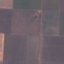

In [ ]:
ex['image']

In [ ]:
ex['label']

0

In [ ]:
#lookup table from label to id and id to label 

id2label = {k:v for k,v in enumerate(labels)}
label2id = {v:k for v,k in enumerate(labels)}

In [ ]:
id2label

In [ ]:
label2id

### **Push dataset to hugging face**

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
dataset.push_to_hub("Amite5h/Eurosat-Datast")

In [ ]:
from datasets import load_dataset

In [ ]:
dataset = load_dataset("Amite5h/Eurosat-Datast")

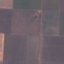

In [ ]:
dataset["train"][0]["image"]

### **Process Data**

In [26]:
from transformers import ConvNextFeatureExtractor
#https://huggingface.co/facebook/convnextv2-base-22k-224

feature_extractor = ConvNextFeatureExtractor.from_pretrained("facebook/convnext-tiny-224")

In [ ]:
print(feature_extractor)

In [31]:
feature_extractor.size["shortest_edge"]

224

In [36]:
#https://pytorch.org/vision/0.9/transforms.html
# We have to do same transform that happend on training images of ConvNextFeatureExtractor

from torchvision.transforms import (
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    ToTensor
)

normalize = Normalize(mean= feature_extractor.image_mean,std=feature_extractor.image_std)

transform = Compose(
    [                RandomResizedCrop(feature_extractor.size["shortest_edge"]),
                     RandomHorizontalFlip(),
                     ToTensor(),
                     normalize
                     ]
                    )

def train_transforms(examples):
  examples["pixel_values"] = [transform(image.convert('RGB')) for image in examples["image"]]

  return examples

In [33]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 27000
    })
})

In [37]:
processed_dataset = dataset.with_transform(train_transforms)

In [38]:
processed_dataset["train"][0]["pixel_values"].shape

torch.Size([3, 224, 224])

### **Define Model**

In [40]:
from transformers import AutoModelForImageClassification 
#https://huggingface.co/facebook/convnextv2-base-22k-224

model = AutoModelForImageClassification.from_pretrained("facebook/convnext-tiny-224",
                                                        num_labels=len(labels),
                                                        id2label=id2label,
                                                        label2id=label2id,
                                                        ignore_mismatched_sizes=True)

Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-tiny-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Device agnoistic code

In [42]:
import torch

device = 'cuda' if torch.cuda.is_available() else "cpu"

model.to(device)

ConvNextForImageClassification(
  (convnext): ConvNextModel(
    (embeddings): ConvNextEmbeddings(
      (patch_embeddings): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (layernorm): ConvNextLayerNorm()
    )
    (encoder): ConvNextEncoder(
      (stages): ModuleList(
        (0): ConvNextStage(
          (downsampling_layer): Identity()
          (layers): Sequential(
            (0): ConvNextLayer(
              (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
              (layernorm): ConvNextLayerNorm()
              (pwconv1): Linear(in_features=96, out_features=384, bias=True)
              (act): GELUActivation()
              (pwconv2): Linear(in_features=384, out_features=96, bias=True)
              (drop_path): Identity()
            )
            (1): ConvNextLayer(
              (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
              (layernorm): ConvNextLayerNorm()
              

Check which GPU you got


In [45]:
!nvidia-smi

Thu May 25 17:14:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    29W /  70W |    727MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [47]:
from torch.utils.data import DataLoader
#https://pytorch.org/docs/stable/data.html


#collate_fn - dataset has 3 fields but loader required only two fields so convert it 
#DataLoader has one argument also which is collate_fn can solve this problem
def collate_fn(examples):
  pixel_value = torch.stack([example["pixel_values"] for example in examples])
  labels = torch.tensor([example["label"] for example in examples])

  return {"pixel_value":pixel_value,"labels":labels}

dataloader = DataLoader(processed_dataset["train"],collate_fn=collate_fn,batch_size=4, shuffle=True)

Here dataloader is an iterable and passing through iter() will return a itrator on which we can iterate . `next()` will give the first then calling again will give next batch 

In [48]:
batch = next(iter(dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_value torch.Size([4, 3, 224, 224])
labels torch.Size([4])


In [52]:
batch["pixel_value"].shape

torch.Size([4, 3, 224, 224])

In [54]:
batch = iter(dataloader)

In [ ]:
next(batch)

In [ ]:
next(batch)

after calling next we are getting batches of 4 images and label . 

### **Train Model**

In [62]:
from tqdm.notebook import tqdm 

optimizer = torch.optim.AdamW(model.parameters(),lr = 5e-5)

model.train()

for epoch in range(5):
  print("Epoch:",epoch)
  correct = 0 
  total = 0
  for idx,batch in enumerate(tqdm(dataloader)):
    #move batch to GPU 
    batch = {k:v.to(device) for k,v in batch.items()}

    #first step of pytorch training loop
    optimizer.zero_grad()

    #forward pass 
    outputs = model(pixel_values = batch["pixel_value"],labels = batch["labels"])

    #get the loss
    loss , logits = outputs.loss,outputs.logits

    #calculate the gradients 
    loss.backward()

    #update the weights 
    optimizer.step()

    #metrics 
    total += batch["labels"].shape[0]
    predicted = logits.argmax(-1)
    correct += (predicted == batch["labels"]).sum().item()

    accuracy = correct/total

    if idx % 100 == 0:
      print(f"Loss after {idx} steps:",loss.item())
      print(f"Accuracy after {idx} steps:",accuracy)


Epoch: 0


  0%|          | 0/6750 [00:00<?, ?it/s]

Loss after 0 steps: 0.09316495060920715
Accuracy after 0 steps: 1.0
Loss after 100 steps: 1.227954626083374
Accuracy after 100 steps: 0.9529702970297029
Loss after 200 steps: 0.03367786109447479
Accuracy after 200 steps: 0.9589552238805971
Loss after 300 steps: 0.005298287607729435
Accuracy after 300 steps: 0.957641196013289
Loss after 400 steps: 0.6518742442131042
Accuracy after 400 steps: 0.9588528678304239
Loss after 500 steps: 0.005025466904044151
Accuracy after 500 steps: 0.9605788423153693
Loss after 600 steps: 1.3305470943450928
Accuracy after 600 steps: 0.9608985024958403
Loss after 700 steps: 0.772098958492279
Accuracy after 700 steps: 0.9597004279600571
Loss after 800 steps: 0.0009612792055122554
Accuracy after 800 steps: 0.9606741573033708
Loss after 900 steps: 0.8458327054977417
Accuracy after 900 steps: 0.9594894561598224
Loss after 1000 steps: 0.2505064606666565
Accuracy after 1000 steps: 0.9595404595404595
Loss after 1100 steps: 0.003687297459691763
Accuracy after 1100 s

  0%|          | 0/6750 [00:00<?, ?it/s]

Loss after 0 steps: 0.0015470522921532393
Accuracy after 0 steps: 1.0
Loss after 100 steps: 0.11219847947359085
Accuracy after 100 steps: 0.9603960396039604
Loss after 200 steps: 0.013325828127563
Accuracy after 200 steps: 0.9651741293532339
Loss after 300 steps: 0.17396335303783417
Accuracy after 300 steps: 0.9642857142857143
Loss after 400 steps: 0.0319666713476181
Accuracy after 400 steps: 0.9663341645885287
Loss after 500 steps: 0.015655014663934708
Accuracy after 500 steps: 0.9645708582834331
Loss after 600 steps: 0.004397902637720108
Accuracy after 600 steps: 0.9638103161397671
Loss after 700 steps: 0.015488673001527786
Accuracy after 700 steps: 0.9646932952924394
Loss after 800 steps: 0.0024196018930524588
Accuracy after 800 steps: 0.9675405742821473
Loss after 900 steps: 0.006485465914011002
Accuracy after 900 steps: 0.9678135405105438
Loss after 1000 steps: 0.0007684180745854974
Accuracy after 1000 steps: 0.9675324675324676
Loss after 1100 steps: 0.5115209817886353
Accuracy af

  0%|          | 0/6750 [00:00<?, ?it/s]

Loss after 0 steps: 0.0012304194970056415
Accuracy after 0 steps: 1.0
Loss after 100 steps: 0.0009205314563587308
Accuracy after 100 steps: 0.9653465346534653
Loss after 200 steps: 0.0012163378996774554
Accuracy after 200 steps: 0.9713930348258707
Loss after 300 steps: 0.02281775325536728
Accuracy after 300 steps: 0.967607973421927
Loss after 400 steps: 0.18143513798713684
Accuracy after 400 steps: 0.9713216957605985
Loss after 500 steps: 0.021207965910434723
Accuracy after 500 steps: 0.969061876247505
Loss after 600 steps: 0.010992137715220451
Accuracy after 600 steps: 0.9679700499168054
Loss after 700 steps: 0.0027156281284987926
Accuracy after 700 steps: 0.9661198288159771
Loss after 800 steps: 0.010066365823149681
Accuracy after 800 steps: 0.964107365792759
Loss after 900 steps: 1.0157641172409058
Accuracy after 900 steps: 0.9636514983351832
Loss after 1000 steps: 0.7364670634269714
Accuracy after 1000 steps: 0.9630369630369631
Loss after 1100 steps: 0.0019615294877439737
Accuracy 

  0%|          | 0/6750 [00:00<?, ?it/s]

Loss after 0 steps: 0.002651681425049901
Accuracy after 0 steps: 1.0
Loss after 100 steps: 0.02293003909289837
Accuracy after 100 steps: 0.9628712871287128
Loss after 200 steps: 0.0032920814119279385
Accuracy after 200 steps: 0.9763681592039801
Loss after 300 steps: 0.002846461720764637
Accuracy after 300 steps: 0.9767441860465116
Loss after 400 steps: 0.0280339103192091
Accuracy after 400 steps: 0.9738154613466334
Loss after 500 steps: 0.009452244266867638
Accuracy after 500 steps: 0.9715568862275449
Loss after 600 steps: 0.0024040325079113245
Accuracy after 600 steps: 0.9721297836938436
Loss after 700 steps: 0.006410573143512011
Accuracy after 700 steps: 0.9711126961483595
Loss after 800 steps: 0.0949832946062088
Accuracy after 800 steps: 0.9715980024968789
Loss after 900 steps: 0.0018456578254699707
Accuracy after 900 steps: 0.9722530521642619
Loss after 1000 steps: 0.00047052899026311934
Accuracy after 1000 steps: 0.9722777222777222
Loss after 1100 steps: 0.383741170167923
Accuracy

  0%|          | 0/6750 [00:00<?, ?it/s]

Loss after 0 steps: 0.001193337608128786
Accuracy after 0 steps: 1.0
Loss after 100 steps: 0.05789724737405777
Accuracy after 100 steps: 0.9702970297029703
Loss after 200 steps: 0.2859206199645996
Accuracy after 200 steps: 0.9676616915422885
Loss after 300 steps: 0.019772622734308243
Accuracy after 300 steps: 0.96843853820598
Loss after 400 steps: 0.464743435382843
Accuracy after 400 steps: 0.9694513715710723
Loss after 500 steps: 0.0910671204328537
Accuracy after 500 steps: 0.967564870259481
Loss after 600 steps: 0.050560854375362396
Accuracy after 600 steps: 0.9675540765391015
Loss after 700 steps: 0.0006919776787981391
Accuracy after 700 steps: 0.9679029957203994
Loss after 800 steps: 0.005429178476333618
Accuracy after 800 steps: 0.968789013732834
Loss after 900 steps: 0.0011442424729466438
Accuracy after 900 steps: 0.9689234184239733
Loss after 1000 steps: 1.0146945714950562
Accuracy after 1000 steps: 0.9682817182817183
Loss after 1100 steps: 0.00376324076205492
Accuracy after 110

### **Push to Hub**

In [63]:
repo_name = "Amite5h/convnext-tiny-finetuned-eurosat"

model.push_to_hub(repo_name)
feature_extractor.push_to_hub(repo_name)

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/111M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Amite5h/convnext-tiny-finetuned-eurosat/commit/6df951ae7ef0e351817a9580fd11cff1153b48f2', commit_message='Upload feature extractor', commit_description='', oid='6df951ae7ef0e351817a9580fd11cff1153b48f2', pr_url=None, pr_revision=None, pr_num=None)

### **Inference**

In [64]:
from transformers import AutoFeatureExtractor, AutoModelForImageClassification

feature_extractor = AutoFeatureExtractor.from_pretrained("Amite5h/convnext-tiny-finetuned-eurosat")
model = AutoModelForImageClassification.from_pretrained("Amite5h/convnext-tiny-finetuned-eurosat")


/usr/local/lib/python3.10/dist-packages/transformers/models/convnext/feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(


In [72]:
import requests
from PIL import Image
from io import BytesIO

def read_image_from_url(url):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))
    return image

In [74]:

url = "https://brasil.amazonteam.org/wp-content/uploads/bb-plugin/cache/feature-image-for-blog-1170x658-panorama.jpg"
image = read_image_from_url(url)

     

In [76]:
pixel_values = feature_extractor(image.convert('RGB'),return_tensors = 'pt').pixel_values
print(pixel_values.shape)

torch.Size([1, 3, 224, 224])


In [77]:
import torch 
with torch.no_grad():
  output = model(pixel_values)
  logits = output.logits
  

In [78]:
logits.shape

torch.Size([1, 10])

In [79]:
predicted_class_idx = logits.argmax(-1).item()
print(model.config.id2label[predicted_class_idx])

Forest
